In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import resnet50
import pkbar
from tqdm import tqdm
import json
import dataset_factory
from experiment import Experiment
import coco_dataset
import vocab
import warnings
warnings.filterwarnings("ignore")

f = open("./default.json")

config = json.load(f)

Using CUDA
Using CUDA


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Running Experiment:  default
loading annotations into memory...
Done (t=1.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Using the saved vocab.
loading annotations into memory...
Done (t=0.97s)
creating index...
index created!
loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/xdg-cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.3MB/s]


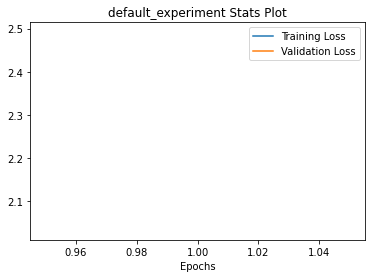

Epoch: 1, Train Loss: 2.491688540309284, Val Loss: 2.0342379964314974, Took 0:08:45.979745, ETA: 1:18:53.817705



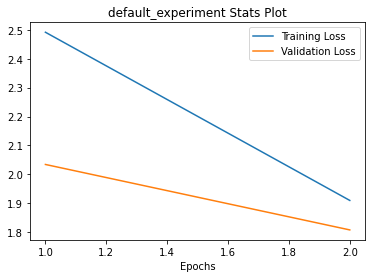

Epoch: 2, Train Loss: 1.9098054720096833, Val Loss: 1.8077716749448043, Took 0:08:46.225023, ETA: 1:10:09.800184



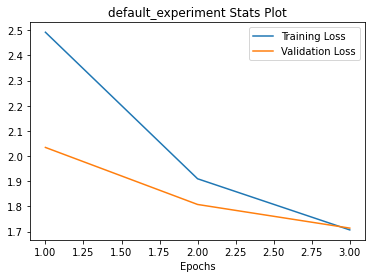

Epoch: 3, Train Loss: 1.7067174501173485, Val Loss: 1.7138449568014877, Took 0:08:20.562359, ETA: 0:58:23.936513



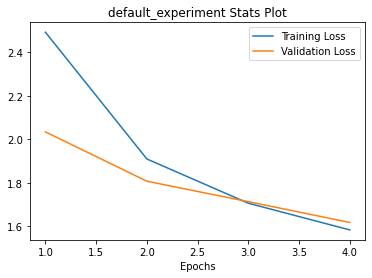

Epoch: 4, Train Loss: 1.584114328423283, Val Loss: 1.6182965397834779, Took 0:08:25.190257, ETA: 0:50:31.141542



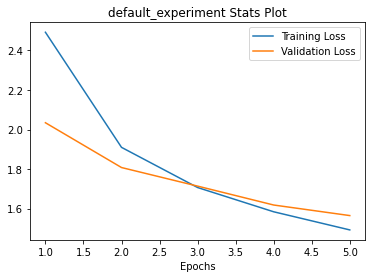

Epoch: 5, Train Loss: 1.4924328849039363, Val Loss: 1.5649112325448256, Took 0:08:28.917373, ETA: 0:42:24.586865



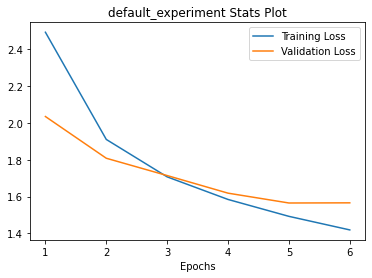

Epoch: 6, Train Loss: 1.418797504390258, Val Loss: 1.5657850545186263, Took 0:09:29.836097, ETA: 0:37:59.344388



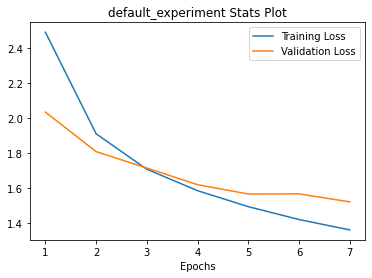

Epoch: 7, Train Loss: 1.3593047386075294, Val Loss: 1.5199442840539492, Took 0:09:10.223528, ETA: 0:27:30.670584



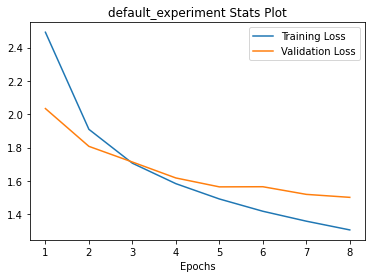

Epoch: 8, Train Loss: 1.3068880969874337, Val Loss: 1.502062777372507, Took 0:09:07.089817, ETA: 0:18:14.179634



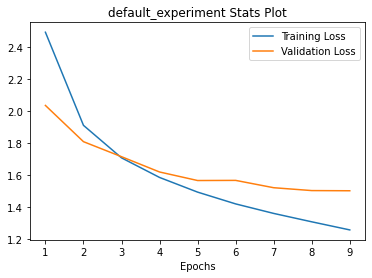

Epoch: 9, Train Loss: 1.2562063172139835, Val Loss: 1.5009287710373218, Took 0:08:49.594419, ETA: 0:08:49.594419



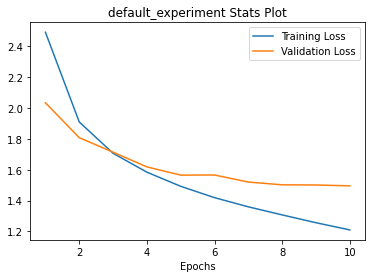

Epoch: 10, Train Loss: 1.2094965797637154, Val Loss: 1.495270070204368, Took 0:08:37.904672, ETA: 0:00:00



  0%|          | 1/235 [00:03<13:46,  3.53s/it]

predicted caption: a fire hydrant is on the side of a road
actual caption: a red fire hydrant stands in a parking lot while a man holding the handle of a tool is in the distance
predicted caption: a man is playing tennis on a court
actual caption: a woman wearing a red tennis outfit holds her racket out to the side near a tennis ball on a tennis court


  1%|▏         | 3/235 [00:03<07:05,  1.83s/it]

predicted caption: a boat with a raft and a boat on it
actual caption: a boat with three people are out in the water and a women is standing over at a ledge talking to someone next to her


  2%|▏         | 5/235 [00:04<03:49,  1.00it/s]

predicted caption: a street sign is on a pole in front of a building
actual caption: woman hangs off of street sign pole like she 's on a pirate ship looking for land
predicted caption: a small plane flying over a beach with a blue sky
actual caption: an action figure with a teddy bear is posed in the snow with a drink umbrella in its hand


  3%|▎         | 7/235 [00:04<02:14,  1.69it/s]

predicted caption: a woman in a red shirt and a hat and a tie
actual caption: a close up of a woman looking at her cell phone in her hand
predicted caption: a stop sign with a sticker on it
actual caption: an upside down road sign showing three different `` only '' options on where your lane will take you


  3%|▎         | 8/235 [00:04<01:47,  2.11it/s]

predicted caption: a woman sitting on a couch with a laptop
actual caption: an older man with a baseball cap on is sitting in the stands at a baseball stadium


  4%|▍         | 9/235 [00:06<03:23,  1.11it/s]

predicted caption: a man and woman are sitting on a bench
actual caption: motorcycle parked in front of a tent with the sun going down behind them


  4%|▍         | 10/235 [00:07<02:55,  1.29it/s]

predicted caption: a man and a woman playing a game of frisbee
actual caption: two men stand under a tree and look at a frisbee that is near two sticks in the ground


  5%|▍         | 11/235 [00:07<02:16,  1.65it/s]

predicted caption: a train is on the tracks near a building
actual caption: a train that is sitting on the tracks with smoke coming out of the top
predicted caption: a large elephant standing in the middle of a field
actual caption: the back ends and legs of three elephants , including a baby , are seen on the side of a road


  6%|▌         | 14/235 [00:08<01:15,  2.94it/s]

predicted caption: a boat is sitting on the sand near the water
actual caption: a swimming pool with lanes marked for racing on the water 's edge across from a large city
predicted caption: a clock tower is on the side of a building
actual caption: a clock is standing in the middle of the grass in the middle of the afternoon


  6%|▋         | 15/235 [00:08<01:05,  3.34it/s]

predicted caption: a cat is laying on the floor and looking out the window
actual caption: a cat looks back over its shoulder while laying on top of a fuzzy white blanket
predicted caption: a man is standing next to a bicycle on the street
actual caption: a motorcycle rider is standing next to his black motor cycle while a red traffic light hangs in the sky


  7%|▋         | 17/235 [00:10<02:44,  1.32it/s]

predicted caption: a bed with a white bedspread and a white blanket
actual caption: two made beds , a nightstand with a lamp , and framed art on the wall


  8%|▊         | 18/235 [00:10<02:21,  1.54it/s]

predicted caption: a group of men playing a game of frisbee
actual caption: school aged girls in street , talking , while one lies on payment with horse drawn carriage in background


  8%|▊         | 19/235 [00:11<02:04,  1.73it/s]

predicted caption: a display of fruit and other fruits in a store
actual caption: a man smiling for camera behind a market produce stand with apples , tomatoes , oranges , with price tags
predicted caption: a bear is standing in the grass near a tree

  9%|▊         | 20/235 [00:11<01:39,  2.16it/s]


actual caption: a panda bear sits in a tree with no branches near a cluster of rocks and a building


  9%|▉         | 21/235 [00:11<01:23,  2.58it/s]

predicted caption: a bed with a white bedspread and a white blanket
actual caption: a room with a large bed , television , dresser and glass doors leading to a balcony


  9%|▉         | 22/235 [00:11<01:14,  2.84it/s]

predicted caption: a baseball player holding a bat on a field
actual caption: a professional ball team with fans in the stands and they have <unk> as a sponsor


 10%|▉         | 23/235 [00:12<01:05,  3.22it/s]

predicted caption: a person riding a snowboard down a snow covered slope
actual caption: a skier is high in the air performing a jump while under a canopy of a dark grey sky


 10%|█         | 24/235 [00:12<00:59,  3.55it/s]

predicted caption: a plate of food with a sandwich and a pickle on it
actual caption: a sandwich , french fries , bowl of ketchup , onion slice , lettuce slice , tomato slice , and knife sit on the white plate


 11%|█         | 25/235 [00:13<02:15,  1.55it/s]

predicted caption: a cake with a plate of food on it
actual caption: a toilet tank lid with a bowl of soaps and seashells and a cup of toothbrushes and toothpaste


 11%|█         | 26/235 [00:14<02:18,  1.51it/s]

predicted caption: a man flying a kite in a field
actual caption: a girl with long hair holds a string and looks up at the kites that are up in the air


 11%|█▏        | 27/235 [00:14<02:01,  1.72it/s]

predicted caption: a group of people playing a game with nintendo wii controllers
actual caption: a guy with a gray sweater and a guy with a blue shirt play video games together
predicted caption: 

 12%|█▏        | 28/235 [00:15<01:36,  2.14it/s]

a white sink sitting next to a sink
actual caption: a toy lizard with a toothbrush in it 's mouth standing next to a running water faucet in a bathroom


 13%|█▎        | 30/235 [00:15<01:07,  3.03it/s]

predicted caption: a group of people sitting on a couch in a living room
actual caption: a girl has presents in front of her near another woman and a dog on a living room floor
predicted caption: a plane flying in the air over a blue sky
actual caption: a plane getting ready to land on a runway with another parked on the side or waiting to take off


 14%|█▎        | 32/235 [00:15<00:53,  3.80it/s]

predicted caption: a cat is sitting on a table with a bottle of coffee
actual caption: a grey and white cat is on a table and stands between a white storage container full of stuff and scissors
predicted caption: a man is sitting on a bench with a skateboard
actual caption: a woman drinking water and a man with a backpack stand by a city bench


 14%|█▍        | 33/235 [00:17<01:49,  1.85it/s]

predicted caption: a red and white bus parked on the side of the road
actual caption: a white bus with a painting of a blue flower on the front stopped on a street near a snow covered sidewalk


 15%|█▍        | 35/235 [00:18<01:43,  1.93it/s]

predicted caption: a traffic light is shown in front of a building
actual caption: a city street that has parked cars on the side of the street and other cars at a traffic light in front of various stores
predicted caption: a traffic light with a street sign on it
actual caption: a look up a street post with a stoplight and sign low with a light on top


 15%|█▌        | 36/235 [00:18<01:24,  2.35it/s]

predicted caption: a living room with a couch , a table and a television
actual caption: a large cushioned chair with a laptop , pillow , remote , a tablet and a cell phone on it


 16%|█▌        | 37/235 [00:18<01:15,  2.62it/s]

predicted caption: a man and woman standing next to each other
actual caption: mostly men in suits posing for a group picture in front of a `` trade winds - asia '' sign


 16%|█▌        | 38/235 [00:18<01:04,  3.04it/s]

predicted caption: a skateboarder is doing a trick on a skateboard
actual caption: a wooden skateboard ramp with a person at the top of the ramp with a skateboard at his feet and other people around the ramp


 17%|█▋        | 40/235 [00:19<00:51,  3.82it/s]

predicted caption: a giraffe is standing in the grass next to a fence
actual caption: a little girl reaches across a fence to pet a giraffe who has his chin up in the air
predicted caption: a cat sitting on top of a bed next to a computer
actual caption: a large dog laying on the floor next to a couch and a dark colored cat laying on the floor to the side of the dog


 17%|█▋        | 41/235 [00:20<01:44,  1.86it/s]

predicted caption: a teddy bear sitting on top of a bed
actual caption: a bed with a cat sleeping on it next to a teddy bear and another cat


 18%|█▊        | 42/235 [00:21<02:17,  1.40it/s]

predicted caption: a man riding a skateboard down a road
actual caption: a blurry skateboarder in the foreground catches some air in what looks like a rail yard


 19%|█▊        | 44/235 [00:22<01:30,  2.12it/s]

predicted caption: a table with a plate of food and a bowl of food
actual caption: a table is covered with plates that have a slice of cake and a plastic fork on them
predicted caption: a group of people standing around a tennis court
actual caption: a basketball court with the head coach dressed in a suit and standing on the court , with a player near him and event staff close by


 20%|█▉        | 46/235 [00:22<01:02,  3.01it/s]

predicted caption: a group of people are standing in the sand
actual caption: people standing and some sitting on the sand of a beach with a kite flying and water in the distance
predicted caption: a man is standing next to a bicycle and a man
actual caption: a man departing a bus onto the street and another man standing next to the bus from the sidewalk


 20%|██        | 47/235 [00:22<00:55,  3.41it/s]

predicted caption: a bus is stopped at a bus stop
actual caption: a double decker transit bus parks by a blue on the side of the street in front of a brick building in the city
predicted caption: a kitchen with a sink , a sink and a stove
actual caption: a white kitchen with plenty of counter space , a dishwasher and a oven


 21%|██        | 49/235 [00:23<01:25,  2.18it/s]

predicted caption: a woman sitting on a bed with a cat and a dog
actual caption: a man holding an umbrella in one hand and a stuffed animal in the other


 21%|██▏       | 50/235 [00:25<02:20,  1.31it/s]

predicted caption: a cat sitting on top of a suitcase
actual caption: a small black cat , sitting under an open umbrella that is resting on the floor


 22%|██▏       | 51/235 [00:25<01:49,  1.68it/s]

predicted caption: a person holding a hot dog in a bun
actual caption: a hot dog with a large pickle in someone 's hand with a background of city buildings


 23%|██▎       | 53/235 [00:25<01:12,  2.52it/s]

predicted caption: a bed with a bed and a lamp on the wall
actual caption: a bed in a hotel is carrying sheets and pillows as it sit next to a lamp
predicted caption: a table with a laptop and a cup of coffee
actual caption: an opened book on a table and something else i do n't know what it is


 23%|██▎       | 55/235 [00:26<00:53,  3.39it/s]

predicted caption: a group of people sitting around a table
actual caption: four women , two holding open umbrellas ; one up and one down , one clapping and one with two fingers up , and one man standing in a row posing for camera on a brick street with shop behind
predicted caption: a man riding a skateboard down a ramp
actual caption: a man riding a skateboard down the rail of some stairs while a group of people watch


 24%|██▍       | 56/235 [00:26<00:47,  3.73it/s]

predicted caption: a group of people riding skis on a snow covered slope
actual caption: a train is stopped in a snowy landscape as people with skis make a trail away from it and one man holding skis smiles for the camera


 24%|██▍       | 57/235 [00:27<01:04,  2.78it/s]

predicted caption: a man standing in the snow with a snowboard
actual caption: three people standing holding ski poles in snow , of which , a man and a woman are smiling into the camera , beside another woman looking away , with evergreens , and two people in distance


 25%|██▌       | 59/235 [00:29<01:45,  1.67it/s]

predicted caption: a table with a plate of food and a bowl of food
actual caption: red wine , coffee and pastries are served there is a statue of a frog riding a snail on the table
predicted caption: a person sitting on a bench in a park
actual caption: a view of a beer bottle and a beach with chairs , an umbrella and the ocean in the background


 26%|██▌       | 60/235 [00:29<01:24,  2.07it/s]

predicted caption: a living room with a couch , chair , and a television
actual caption: a clean and tidy living room with a couch , a table , and a painting on the wall


 26%|██▌       | 61/235 [00:29<01:12,  2.39it/s]

predicted caption: a man riding a horse down a street next to a building
actual caption: a car passes by a horse and carriage on a street with buildings and a tree


 26%|██▋       | 62/235 [00:29<01:01,  2.80it/s]

predicted caption: a man in a suit and tie standing next to a man
actual caption: a laughing german man at a party wearing ridiculous ties and sunglasses <unk> it up for the camera


 27%|██▋       | 63/235 [00:30<00:58,  2.96it/s]

predicted caption: a man holding a smart phone in front of a camera
actual caption: a man with two bottles of beer , a sign , and a wine glass at a counter


 28%|██▊       | 65/235 [00:30<00:46,  3.67it/s]

predicted caption: a man on a boat with a surfboard in the background
actual caption: a man lays on the ground while a skateboard is in the air above the ground
predicted caption: a small plane flying over a beach with a blue sky
actual caption: a toy action figure holding a plastic mini teddy bear and a cocktail glass decoration on the snow


 28%|██▊       | 66/235 [00:32<02:07,  1.33it/s]

predicted caption: a pair of scissors are on a hook in a holder
actual caption: a banana with `` it was really very good '' written on it lays atop a <unk> on a table


 29%|██▊       | 67/235 [00:32<01:39,  1.70it/s]

predicted caption: a woman in a kitchen with a sink and a woman
actual caption: a man in a wheelchair holding a phone to his ear , in front of a cd player and cd 's on the side


 29%|██▉       | 68/235 [00:32<01:19,  2.10it/s]

predicted caption: a red bus is parked in front of a building
actual caption: a street scene shows a red and white bus with trees , a bus stop area , and a brick tower around the <unk>
predicted caption: a dog is laying on the back of a car
actual caption:

 30%|██▉       | 70/235 [00:33<00:55,  2.99it/s]

 a dog who is next to his stuffed toy seems very concerned by whatever is in the background
predicted caption: a cat sitting on a bench in a park
actual caption: the large cat is sitting on the bench on the side of the house where the bike is parked


 30%|███       | 71/235 [00:33<00:48,  3.40it/s]

predicted caption: a desk with a laptop and a laptop on it
actual caption: a laptop sits precariously on a desk , with a second keyboard in front of it , and windows behind it


 31%|███       | 72/235 [00:33<00:43,  3.74it/s]

predicted caption: a table topped with a sandwich and a cup of coffee
actual caption: a picture of a sandwich on a plate on a tray with a drink and a covered side item on a table facing a window


 31%|███       | 73/235 [00:34<00:59,  2.72it/s]

predicted caption: a man holding a surfboard on a beach near a body of water
actual caption: the sand area of a beach that has water on it and a woman with an umbrella over her head standing on the sand


 31%|███▏      | 74/235 [00:35<02:03,  1.31it/s]

predicted caption: a living room with a couch , a table and a television
actual caption: a brown chair has a remote , laptop , phone and yellow pillow on it as it sits in a corner


 32%|███▏      | 75/235 [00:36<01:35,  1.67it/s]

predicted caption: a teddy bear with a tag on it 's face
actual caption: two stuffed animal bears sitting next to a candy bar and a flower pot on a table


 32%|███▏      | 76/235 [00:36<01:19,  1.99it/s]

predicted caption: a bathroom with a toilet and a toilet
actual caption: two clown pictures are hanging on the wall behind the urinal that has a wine glass sitting on top of it


 33%|███▎      | 77/235 [00:36<01:05,  2.40it/s]

predicted caption: a baseball player holding a bat on a field
actual caption: a baseball player with the number 25 on his uniform , with a baseball bat and in a batting stance


 34%|███▎      | 79/235 [00:36<00:47,  3.28it/s]

predicted caption: a pizza with cheese and cheese on it
actual caption: a table that has pizza , wine , a candle , plates , and another food dish on it
predicted caption: a street sign is on a pole in front of a building
actual caption: a large sign that says cave next to a sign that says resturant and lounge


 34%|███▍      | 80/235 [00:37<00:42,  3.65it/s]

predicted caption: a kitchen with a refrigerator and a stove
actual caption: two microwaves sitting side by side on a countertop are marked with signs printed with the symbols for man and woman


 34%|███▍      | 81/235 [00:38<01:20,  1.92it/s]

predicted caption: a large building with a clock on the top of it
actual caption: three horse and buggies are parked out in front of a building that has three steeples


 35%|███▌      | 83/235 [00:39<01:26,  1.76it/s]

predicted caption: a man in a bikini holding a surfboard
actual caption: a man with a beard standing on the beach with a surfboard under his right arm and he is looking out into the ocean
predicted caption: a red and white clock on a pole in front of a building
actual caption: a photo of a `` no entry '' road sign and the top of a building and treetops


 36%|███▌      | 84/235 [00:39<01:09,  2.16it/s]

predicted caption: a woman in a kitchen with a pizza and a plate of food
actual caption: a woman cooking with a large white bot and a cooking board with meat in it in a small kitchen
predicted caption: 

 36%|███▌      | 85/235 [00:40<01:00,  2.50it/s]

a cat is laying on a bed next to a computer
actual caption: a cat looks off the edge of a made up bed that has blue pillows and a floral pillow


 37%|███▋      | 86/235 [00:40<00:51,  2.91it/s]

predicted caption: a dog sitting on the hood of a car
actual caption: a white dog sitting inside a red car next to a string of flowers hanging off the mirror


 37%|███▋      | 87/235 [00:40<00:48,  3.02it/s]

predicted caption: a plate of food with a salad and a bowl of soup
actual caption: the plate with a pair of chop sticks on it is next to a bowl with a spoon in it


 37%|███▋      | 88/235 [00:40<00:43,  3.38it/s]

predicted caption: a cat laying on a bed next to a book
actual caption: a man sleeping in and unfurnished room on a blow up mattress with a sleeping bag


 38%|███▊      | 89/235 [00:42<01:26,  1.69it/s]

predicted caption: a group of people standing in the snow with skis
actual caption: a man and a woman wearing eye protection and coats stands in the snow near a couple of skiers


 38%|███▊      | 90/235 [00:42<01:22,  1.76it/s]

predicted caption: a pair of scissors that are on a wall
actual caption: a black and white clock sits on a black surface near a black and white curtain and a window at night


 39%|███▊      | 91/235 [00:42<01:10,  2.05it/s]

predicted caption: a man and woman are sitting on a bench
actual caption: a man in blue shorts putting together a blue and purple kite on a blue towel at the beach


 39%|███▉      | 92/235 [00:43<01:00,  2.35it/s]

predicted caption: a pair of scissors sitting on a table next to a pair of shoes
actual caption: a small carry-on bag , strapped to the handle of a larger suitcase from the same set of luggage


 40%|███▉      | 93/235 [00:43<00:52,  2.72it/s]

predicted caption: a cat sitting on a couch in front of a television
actual caption: a cat rests on a sofa next to the remote in front of a laptop in a living area


 40%|████      | 94/235 [00:43<00:51,  2.73it/s]

predicted caption: a group of people standing around a table
actual caption: a group of people seated in chairs together and facing the same direction , with one man holding a soccer ball in his hands


 40%|████      | 95/235 [00:44<00:48,  2.88it/s]

predicted caption: a group of people standing on top of a sandy beach
actual caption: many colorful <unk> kites , statues of women in kimono , and a japanese <unk> gate


 41%|████      | 96/235 [00:44<00:43,  3.21it/s]

predicted caption: a dog is sitting on a bed in front of a television
actual caption: a television is on , in front of a white couch with a sheet on top of it


 41%|████▏     | 97/235 [00:45<01:19,  1.74it/s]

predicted caption: a man and woman standing next to each other
actual caption: a man in a suit at wedding reception holding his drink and wiping his <unk>


 42%|████▏     | 98/235 [00:45<01:10,  1.93it/s]

predicted caption: a chocolate cake with a piece of cake on it
actual caption: two yellow plates have a red bird on them while one has a yellow bird on it


 42%|████▏     | 99/235 [00:46<01:05,  2.06it/s]

predicted caption: a cat sitting on a desk next to a keyboard
actual caption: a gray laptop with an apple in the center of the lid sits on a dark surface


 43%|████▎     | 101/235 [00:46<00:45,  2.92it/s]

predicted caption: a zebra standing in the shade of a car
actual caption: a zebra walking down a roadway and a vehicle stopped in the roadway to greet the zebra
predicted caption: a table with a plate of food and a bowl of soup
actual caption: a table is set with three mugs of beer , a slice of pie , a donut with a segment cut out , and few other objects


 44%|████▍     | 103/235 [00:47<00:35,  3.72it/s]

predicted caption: a teddy bear is sitting in the middle of a tree
actual caption: a statue of an elephant with a target on it 's back and the words `` never <unk> '' in a heart
predicted caption: a bathroom with a toilet and a toilet
actual caption: a marble wall is next to a tub and a toilet stands near the tub


 44%|████▍     | 104/235 [00:47<00:32,  4.03it/s]

predicted caption: a woman is sitting on a couch with a teddy bear
actual caption: a man in a brown hat and a green coat sits in a stadium eating a sandwich


 45%|████▍     | 105/235 [00:48<01:25,  1.52it/s]

predicted caption: a person is standing in front of a refrigerator
actual caption: a man and a woman are speaking in a darkened room , in front of a computer on a tall desk


 45%|████▌     | 106/235 [00:49<01:10,  1.83it/s]

predicted caption: a motorcycle parked on the side of a road
actual caption: a white and a black bicycle parked in a concrete bicycle parking station , next to a grass yard area


 46%|████▌     | 107/235 [00:49<01:16,  1.68it/s]

predicted caption: a man riding a wave on a surfboard in the ocean
actual caption: a person stands on one leg on one end of a surfboard while another person holds the other end
predicted caption: a kitchen with a refrigerator and a stove
actual caption:

 46%|████▋     | 109/235 [00:50<00:49,  2.55it/s]

 kitchen with refrigerator , stove , table , sweeper and clock on the wall in red and white decor
predicted caption: a cow is standing in the grass near a fence
actual caption: a cow eating from a woman 's hand while another cow tries to get some too


 47%|████▋     | 111/235 [00:50<00:36,  3.40it/s]

predicted caption: a pair of scissors and a cell phone on a table
actual caption: a smart phone sitting next to a canned soft drink and a pen on a wooden table
predicted caption: a stop sign with a sticker on the side of it
actual caption: a close up of a country sign , the picture is a <unk> bus that is freaking out because it is about to hit a biker , and the sign below reads <unk> <unk> de route '


 48%|████▊     | 112/235 [00:50<00:32,  3.76it/s]

predicted caption: a person is standing in the bathroom of a bathroom sink
actual caption: a toilet cubicle door that you can see through the bottom half , revealing a mans feet and calves standing in front of a toilet


 48%|████▊     | 113/235 [00:51<01:00,  2.02it/s]

predicted caption: a man is playing tennis on a court
actual caption: a man in a blue and white tennis shirt , dark shorts and white cap , playing tennis


 49%|████▊     | 114/235 [00:53<01:24,  1.43it/s]

predicted caption: a wooden bench sitting in front of a building
actual caption: a blue bench in front of a stone style wall and a bush with red flowers to the side of it


 49%|████▉     | 115/235 [00:53<01:19,  1.50it/s]

predicted caption: a group of people are standing in the sand
actual caption: a group of men and women on the beach with striped towels and a yellow surfboard


 50%|████▉     | 117/235 [00:54<00:50,  2.33it/s]

predicted caption: a living room with a couch , chair , and a television
actual caption: a bottle of wine , place settings , and some apples on a coffee table in front of a couch
predicted caption: a group of men standing around a tennis ball
actual caption: three people seated on a bench , one with a tennis racket and a fourth standing


 50%|█████     | 118/235 [00:54<00:45,  2.57it/s]

predicted caption: a person holding a plate of food on a table
actual caption: a cup and bottle of hot sauce are on a table next to a plate with food , a fork , and knife on it


 51%|█████     | 120/235 [00:54<00:33,  3.39it/s]

predicted caption: a bowl of fruit is on a table
actual caption: a delicious fruit plate in a silver bowl the fruit includes an apple , two apricots , red and green grapes , a banana , and a peach
predicted caption: a man standing in a room with a wii remote in his hand
actual caption: a lady is standing in pastel colored bathroom in front of the bathtub and there are christmas lights hanging up outside of the doorway


 51%|█████▏    | 121/235 [00:55<00:43,  2.63it/s]

predicted caption: a toilet with a dolphin and a black and white tiles
actual caption: a pink <unk> that states , `` close the door when you leave ! ! ! <unk> '' attached to an open toilet seat lid


 52%|█████▏    | 122/235 [00:56<01:04,  1.74it/s]

predicted caption: a cat is laying on top of a keyboard
actual caption: a cat standing in front of a television screen with a picture of a fish


 52%|█████▏    | 123/235 [00:57<01:07,  1.65it/s]

predicted caption: a man and woman are standing together in a room
actual caption: a woman in a bridal gown holding flowers is posing next to a man in a shirt and tie


 53%|█████▎    | 124/235 [00:57<00:54,  2.04it/s]

predicted caption: a bus is stopped at a bus stop
actual caption: a street shot centers mainly on a bus alongside a sidewalk with a sign and bus stop <unk> , that is also right behind the rear part of a second bus , though a <unk> section past the bus shows trees and a turning truck


 54%|█████▎    | 126/235 [00:57<00:37,  2.94it/s]

predicted caption: a table with a plate of food and a bowl of food
actual caption: a large table containing several bottles of juice , a pizza , a pan of food , plates , napkins and plastic utensils
predicted caption: a person is sitting on a couch with a laptop
actual caption: a woman is working with orange and white fabric and several <unk> of colored thread on top of a table


 54%|█████▍    | 128/235 [00:58<00:28,  3.73it/s]

predicted caption: a street sign is on a pole in front of a building
actual caption: an green and white overhead street sign on interstate <unk> for queens and <unk> , showing a truck <unk>
predicted caption: a traffic light and traffic light on a city street
actual caption: a row of buildings and a city street on a hill that is pretty steep


 55%|█████▍    | 129/235 [00:58<00:32,  3.24it/s]

predicted caption: a pizza sitting on top of a table
actual caption: a view of a a pizza sitting on a table , with a person taking it off the tray


 55%|█████▌    | 130/235 [01:00<01:28,  1.19it/s]

predicted caption: a cow standing in the middle of a field
actual caption: green fields with shrubs and gentle rises and dips in the terrain has a large black cow standing on it , <unk> , and a second one that is looking around at the other one


 56%|█████▌    | 131/235 [01:01<01:16,  1.36it/s]

predicted caption: a bathroom with a toilet and a toilet
actual caption: this floor has a pattern of black and white tiles the sink is the same pattern


 56%|█████▌    | 132/235 [01:01<00:59,  1.73it/s]

predicted caption: a zebra standing on top of a lush green field
actual caption: a mother zebra feeding a baby zebra while another zebra stands with its head above the mother zebra 's back


 57%|█████▋    | 133/235 [01:01<00:50,  2.03it/s]

predicted caption: a man is cooking in a restaurant with a pizza
actual caption: the remnants of pizzas are lined up on a long table with kids playing with a phone


 57%|█████▋    | 134/235 [01:01<00:41,  2.42it/s]

predicted caption: a baby sitting in a crib with a stuffed animal
actual caption: a female looking at a baby that is attached to an <unk> tube and a <unk> circuit in addition to two <unk> in the background ; a <unk> <unk> <unk> and a <unk> <unk> ventilator


 57%|█████▋    | 135/235 [01:02<00:36,  2.71it/s]

predicted caption: a bowl of fruit is on a table
actual caption: a long bowl with variety of fruits laid out in it in front of a plate with a napkin


 58%|█████▊    | 136/235 [01:02<00:32,  3.05it/s]

predicted caption: a man and a woman are flying a kite in a park
actual caption: kite flying , unusual designed , orange oval shaped with man dressed in blue jacket , head cap but wearing shorts , on grass plateau , mountain back ground partly cloudy blue sky


 58%|█████▊    | 137/235 [01:02<00:30,  3.16it/s]

predicted caption: a person laying in bed reading a book and a dog
actual caption: a young girl is petting a dog on the couch with a lady looking on


 59%|█████▊    | 138/235 [01:04<01:08,  1.42it/s]

predicted caption: a cake with a chocolate face on it and a plate of food on it
actual caption: a chocolate cake with a bottle of shaving cream scissors and a brush sitting on top of it


 59%|█████▉    | 139/235 [01:05<01:24,  1.13it/s]

predicted caption: a small airplane is parked on the runway
actual caption: a mack truck is pulled up to a station area where an employee opens the door


 60%|█████▉    | 140/235 [01:05<01:04,  1.46it/s]

predicted caption: a bathroom with a sink and a mirror
actual caption: a white colored vanity area with a mirror , sink and double light on the wall above the mirror


 60%|██████    | 141/235 [01:06<00:52,  1.80it/s]

predicted caption: a man and a woman holding a tennis racquet
actual caption: four men standing against a brick wall with one of them eating from a food container , one with several carrots stuffed into him mouth and the other two standing next to them


 60%|██████    | 142/235 [01:06<00:42,  2.20it/s]

predicted caption: a train is on the tracks at a station
actual caption: a train traveling down a track in the middle of the day it 's covered in graffiti


 61%|██████    | 143/235 [01:06<00:37,  2.47it/s]

predicted caption: a dog is sitting in the grass with a frisbee
actual caption: a dog with it 's mouth open and head next to the window of a car , looking out of the vehicle


 62%|██████▏   | 145/235 [01:06<00:27,  3.30it/s]

predicted caption: a plate of food with a salad and a fork
actual caption: a fried egg with a <unk> yolk tops a mini whole wheat pizza made with melted cheese and spinach
predicted caption: a bathroom with a toilet and a toilet
actual caption: two empty toilet paper roll holders hang in the stall while the <unk> lay around and a nice roll sets on the bar


 62%|██████▏   | 146/235 [01:08<00:53,  1.67it/s]

predicted caption: a motorcycle parked on the side of a road
actual caption: a motorcyclist sits on the ground next to his motorcycle in the middle of a road in a wooded area


 63%|██████▎   | 147/235 [01:09<01:19,  1.11it/s]

predicted caption: a woman is sitting at a table with a plate of food
actual caption: a man sitting at a table with a burrito and a cup of coffee in front of him


 63%|██████▎   | 148/235 [01:10<01:00,  1.44it/s]

predicted caption: a horse is standing in a parking lot
actual caption: a tanker truck driving down a road with two people riding an elephant on the side of the road behind the passing truck


 63%|██████▎   | 149/235 [01:10<00:47,  1.82it/s]

predicted caption: a man is sitting at a table with a plate of food
actual caption: a person in a helmet is eating a snack , with a glass of water , in front of her blue parked bike


 64%|██████▍   | 150/235 [01:10<00:37,  2.24it/s]

predicted caption: a group of men playing a game of frisbee
actual caption: girl laying down in the street with others look on and a horse drawn carriage parked at the curb
predicted caption: a group of young men playing a game of soccer
actual caption: a row of men wearing striped shirts stand on a tennis court next to a man in a black t-shirt


 65%|██████▍   | 152/235 [01:10<00:27,  2.97it/s]

predicted caption: a man is holding a tennis racket on a court
actual caption: a young boy is in a tennis court and has his hand with the racket up and ready to receive a tennis ball


 65%|██████▌   | 153/235 [01:11<00:24,  3.36it/s]

predicted caption: a bathroom with a toilet and a toilet
actual caption: the toilet paper containers in this public restroom are empty and need to be <unk>


 66%|██████▌   | 154/235 [01:11<00:35,  2.25it/s]

predicted caption: a man riding a horse in the water
actual caption: a person standing on a wet sand beach next to three elephants wading in the water


 66%|██████▌   | 155/235 [01:12<00:44,  1.79it/s]

predicted caption: a bathroom with a toilet and a sink
actual caption: a bathroom that has a tub , a toilet , a sink , and a mirror


 66%|██████▋   | 156/235 [01:12<00:35,  2.21it/s]

predicted caption: a large elephant standing in the middle of a field
actual caption: an elephant with tusks standing in a rock strewn grassy area with two birds perched on top of it


 67%|██████▋   | 157/235 [01:13<00:30,  2.52it/s]

predicted caption: a pizza sitting on top of a table
actual caption: a table containing two pizzas covered with green beans and spinach next to a bottle of beer and a glass of wine


 68%|██████▊   | 159/235 [01:13<00:22,  3.34it/s]

predicted caption: a woman is holding a teddy bear in her hand
actual caption: a doll with huge eyes and black hair with <unk> bangs holds a red umbrella
predicted caption: a television and a television on a table
actual caption: a laptop sitting on a table with two chairs near a railing in some sort of shop


 68%|██████▊   | 160/235 [01:13<00:20,  3.71it/s]

predicted caption: a zebra standing on top of a lush green field
actual caption: a captive zebra nuzzles in the grass as an ostrich stands in the shade beneath the trees to the left


 69%|██████▊   | 161/235 [01:14<00:20,  3.66it/s]

predicted caption: a woman and woman sitting at a table with a pizza
actual caption: two guys are sitting down at a table and one is holding a yellow napkin on his lap and a person in red is taking a picture of a plate of food


 69%|██████▉   | 162/235 [01:15<00:49,  1.48it/s]

predicted caption: a cake is on a table with a knife and a knife
actual caption: a hand holding a piece of cake with a bite out of it in front of a black and white cat


 70%|██████▉   | 164/235 [01:16<00:33,  2.10it/s]

predicted caption: a herd of sheep standing on top of a grass covered field
actual caption: a sheep stands alert with it 's face to the camera while it 's offspring , head hidden by the sheep 's wool , drinks it 's mother 's milk
predicted caption: a horse drawn carriage with a man on a leash
actual caption: a street that has three cows walking down the street together and people on the sidewalk area


 71%|███████   | 166/235 [01:16<00:23,  2.99it/s]

predicted caption: a bathroom with a toilet and a toilet
actual caption: this bathroom has a toilet that sits back in a small niche and a shower with sliding glass doors
predicted caption: a group of people sitting on a bench in a park
actual caption: a group of people on a bust street area with one person holding a multicolored umbrella over head


 71%|███████   | 167/235 [01:16<00:20,  3.37it/s]

predicted caption: a man is sitting at a table with a laptop
actual caption: a sitting area with furniture and flowers makes a backdrop for a boy with headphones , sitting in the foreground at one of the chairs at a dining table that holds glasses and a handbag , working at a laptop


 72%|███████▏  | 169/235 [01:17<00:17,  3.74it/s]

predicted caption: a man riding a wave on a surfboard in the ocean
actual caption: one person holds the back of a surfboard while another person stands on the front of it on one leg
predicted caption: a table with a plate of food and a bowl of food
actual caption: two boxes of pizza sit on a wood table and one of the boxes is closed while the other is open to reveal a whole pizza inside of it


 73%|███████▎  | 171/235 [01:19<00:40,  1.58it/s]

predicted caption: a cat is laying on a couch with a remote control
actual caption: a person in a pink skirt and blue shoes standing in front of a cat sitting on a rug
predicted caption: a cat is sitting on a bench outside
actual caption: a white and gray cat with a striped tail crouches on a park bench under some bushes


 73%|███████▎  | 172/235 [01:19<00:31,  1.99it/s]

predicted caption: a man riding a bike on a city street
actual caption: a man on a motorcycle that is on a road that has grass fields on both sides and a stop sign


 74%|███████▎  | 173/235 [01:20<00:25,  2.43it/s]

predicted caption: a horse drawn carriage with a man standing on top of it
actual caption: black cows following one another across the street brown cow of horse watching on from the other side


 74%|███████▍  | 174/235 [01:20<00:22,  2.67it/s]

predicted caption: a parking meter is on the side of a road
actual caption: a old blue rusted meter is standing on the side of a street , in front of a plant pot


 75%|███████▍  | 176/235 [01:20<00:16,  3.47it/s]

predicted caption: a bathroom with a toilet , sink and a bathtub
actual caption: a small tiled bathroom with a sink and a toilet with the tank high above the toilet
predicted caption: a chocolate cake with a piece of cake on it
actual caption: a piece of cake sitting on top of a plate covered in marshmallow with a lit candle sticking out of it


 75%|███████▌  | 177/235 [01:21<00:15,  3.79it/s]

predicted caption: a man and woman sitting on a bench in a park
actual caption: two men have stopped in a field while one of them in a white shirt fixes the other man 's tie


 76%|███████▌  | 178/235 [01:22<00:37,  1.53it/s]

predicted caption: a traffic light is on a pole in front of a building
actual caption: a pole holding a traffic sign and two traffic lights in front of a building


 76%|███████▌  | 179/235 [01:22<00:29,  1.92it/s]

predicted caption: a woman sitting on a bench with a dog
actual caption: a man on his cell phone , wearing a leather jacket , gazing toward low mountains


 77%|███████▋  | 180/235 [01:23<00:23,  2.34it/s]

predicted caption: a woman holding a baby dryer in a room
actual caption: a man with glasses looking at himself in the mirror with a toothbrush in his hand


 77%|███████▋  | 182/235 [01:23<00:16,  3.20it/s]

predicted caption: a person holding a hot dog in front of a bun
actual caption: a woman is eating outside with a small picture of a truck in the corner of the photo
predicted caption: a woman is sitting at a table with a plate of food
actual caption: a woman sits at a table with a pan of pasta in front of her , and a slice on her plate


 78%|███████▊  | 183/235 [01:23<00:14,  3.59it/s]

predicted caption: a boat with a raft and a boat in the water
actual caption: artwork of a ship with three masts and one sail open with a <unk> and crossbones on it , in bluish gray water with gray cement wall in background
predicted caption: a stop sign with a sticker on the side of it
actual caption: a red and white street sign mounted on a red pole with a pedestrian traffic light


 79%|███████▊  | 185/235 [01:24<00:11,  4.20it/s]

predicted caption: a train on a track near a building
actual caption: a terraced hill in fall colors going down to the water with a boat on it


 79%|███████▉  | 186/235 [01:25<00:28,  1.72it/s]

predicted caption: a person holding a banana in their hand and a dog
actual caption: a sugar doughnut with a bite out of it is held out by two fingers


 80%|███████▉  | 187/235 [01:25<00:22,  2.12it/s]

predicted caption: a traffic light is shown in front of a building
actual caption: a traffic light is standing in the middle of the street as buses are driving in the background


 80%|████████  | 188/235 [01:25<00:19,  2.40it/s]

predicted caption: a pizza with cheese and cheese on it
actual caption: a pan with ham on it sitting on top of an oven with a knife next to it


 81%|████████  | 190/235 [01:26<00:13,  3.24it/s]

predicted caption: a man in a kitchen with a sink
actual caption: a man dressed in a helmet and goggles indoors has a goofy smile on and his hand raised
predicted caption: a kitchen with a stove and a microwave
actual caption: there are pans on the stove and one of the pans has food cooking in it


 81%|████████▏ | 191/235 [01:26<00:12,  3.60it/s]

predicted caption: a pair of scissors and a cell phone on a table
actual caption: a soda can , a pen , a cell phone and a fruit drink mix packet sitting on a table with a computer keyboard
predicted caption: a motorcycle parked on the side of a road
actual caption: two motorcycles parked next to each other on a green grassy area next to a tree and shrubbery


 82%|████████▏ | 193/235 [01:26<00:10,  4.15it/s]

predicted caption: a woman holding an umbrella and a dog in a park
actual caption: a person wearing <unk> 's is holding a multicolored umbrella while walking on the sidewalk by a brick building


 83%|████████▎ | 195/235 [01:29<00:22,  1.74it/s]

predicted caption: a person holding a large dog in a kitchen
actual caption: two cups of ice cream sitting on a table in front of a woman with whipped cream and a cherry on top
predicted caption: a motorcycle parked on the side of a road
actual caption: motorcycle sitting on a dirt road in front of a farm house advertising produce


 83%|████████▎ | 196/235 [01:29<00:18,  2.06it/s]

predicted caption: a dog is looking at a dog on the ground
actual caption: a brown dog crouches by a black bag as a gray and brown dog is under a black chair


 84%|████████▍ | 197/235 [01:29<00:16,  2.30it/s]

predicted caption: a herd of sheep grazing on a lush green field
actual caption: while in the immediate foreground juts a gnarled tree branch , the majority of the view consists of a an expanse of short grass dotted with a few longer tufts and a number of scattered , grazing sheep


 84%|████████▍ | 198/235 [01:29<00:13,  2.72it/s]

predicted caption: a clock on a wall with a clock on it
actual caption: a tall building with a round glass window and a sculpture of a creepy old man 's face above it


 85%|████████▍ | 199/235 [01:30<00:12,  2.94it/s]

predicted caption: a motorcycle parked on the side of a road
actual caption: a store that says `` ray 's tavern '' and a group of motorcycles parked outside the store


 85%|████████▌ | 200/235 [01:30<00:10,  3.27it/s]

predicted caption: a bunch of people in a market with fruit and fruit
actual caption: view of a market with many ripe and green bananas , hanging and on tables under tents , with people and a motorcycle


 86%|████████▌ | 201/235 [01:30<00:10,  3.36it/s]

predicted caption: a bird sitting on a branch in the middle of the tree
actual caption: a small bird stands on the tip of a tree branch against the blue sky


 86%|████████▋ | 203/235 [01:32<00:18,  1.77it/s]

predicted caption: a living room with a couch , chairs , a television and a television
actual caption: view of a home , living room , and dining room with cabinets , books , and assorted furniture
predicted caption: a person is skiing on a snowy hill
actual caption: a pair of green , yellow and orange skis sit next to a pair of green ski boots


 87%|████████▋ | 204/235 [01:32<00:14,  2.19it/s]

predicted caption: a man and a woman sitting on a couch
actual caption: a girl making a `` peace sign '' with her hand and a woman holding a big black suitcase


 87%|████████▋ | 205/235 [01:33<00:18,  1.61it/s]

predicted caption: a zebra standing in the grass next to a tree
actual caption: birds rest on the back of a zebra while it and a giraffe goes for a drink


 88%|████████▊ | 206/235 [01:33<00:14,  2.00it/s]

predicted caption: a plate of food with a sandwich and a pickle on it
actual caption: a plate of food which includes onions , tomato , lettuce , sauce , fries , and a sandwich


 88%|████████▊ | 207/235 [01:34<00:11,  2.34it/s]

predicted caption: a man sitting at a table with a laptop
actual caption: two <unk> stand at booths in front of laptop computers in a dark room with stars being projected on the walls


 89%|████████▊ | 208/235 [01:34<00:09,  2.75it/s]

predicted caption: a group of people standing in the snow with skis
actual caption: a group of young men standing next to each other in front of a white wall


 89%|████████▉ | 209/235 [01:34<00:08,  2.93it/s]

predicted caption: a man and a woman are flying a kite in a park
actual caption: a person standing in a green field over looking a valley and mountains flying a kite


 89%|████████▉ | 210/235 [01:36<00:17,  1.44it/s]

predicted caption: a cat is laying on the floor and looking out the window
actual caption: the dog is laying down underneath the table because he is in trouble for chewing on things he should n't have chewed on


 90%|████████▉ | 211/235 [01:36<00:13,  1.83it/s]

predicted caption: a man is standing on a bench next to a building
actual caption: a yellow fire hydrant at the edge of a sidewalk with the edge of the sidewalk painted red


 90%|█████████ | 212/235 [01:36<00:10,  2.24it/s]

predicted caption: a man riding a motorcycle on a city street
actual caption: a person in motorcycle apparel from the back , standing in front of a person in motorcycle apparel on a motorcycle from the side , on <unk> surface by water


 91%|█████████ | 213/235 [01:37<00:09,  2.34it/s]

predicted caption: a red and white fire hydrant in the middle of a city
actual caption: twenty five different pictures , some of plants , some of people and some of water , but all have the color green


 91%|█████████▏| 215/235 [01:37<00:06,  3.20it/s]

predicted caption: a man and woman are standing together in a room
actual caption: a young boy stands around a busy area , wearing a white shirt with a yellow tie and a name tag
predicted caption: a computer monitor and a laptop on a desk
actual caption: a desk holds a laptop , mouse , modem , and a lamp and there is a brown chair in front of it


 92%|█████████▏| 216/235 [01:37<00:05,  3.25it/s]

predicted caption: a man and woman standing in front of a cake
actual caption: two men sitting at a table filled with bottles , cups and wine glasses
predicted caption: a bus is stopped at a bus stop
actual caption: a street view , left , shows a curb with a yellow fire hydrant and a big bus , holding a bicycle in front , and to the right , an island with cars moving on either side , and far off street signs , a crosswalk with pedestrians , and buildings


 93%|█████████▎| 219/235 [01:40<00:12,  1.31it/s]

predicted caption: a man in a bikini holding a surfboard on a beach
actual caption: a man in a wetsuit standing at the very edge of some water while holding a surfboard
predicted caption: a man is holding a tennis racket on a court
actual caption: male tennis play in backhand position , fixing to hit low ball which is not shown


 94%|█████████▎| 220/235 [01:41<00:08,  1.67it/s]

predicted caption: a stop sign with a sticker on it
actual caption: a picture of a street upside down , showing that the street signs with directional arrows was posted upside down


 94%|█████████▍| 221/235 [01:41<00:06,  2.08it/s]

predicted caption: a group of people riding motorcycles down a street
actual caption: a group of people in next to motor scooters , in front of a store with asian character writing on the awnings


 95%|█████████▍| 223/235 [01:41<00:04,  2.85it/s]

predicted caption: a vase with flowers in it sitting on a table
actual caption: a vase filled with a red and yellow flower arrangement in front of a brick pillar
predicted caption: a man and woman standing next to each other
actual caption: a young man in a suit with his arm around the shoulder a shorter older man , also in a suit


 96%|█████████▌| 225/235 [01:42<00:02,  3.83it/s]

predicted caption: a woman and a girl sitting on a bench
actual caption: a little girl stands on one leg as she plays with a remote while another person lounges in the background on a couch
predicted caption: a display of different types of luggage
actual caption: a banana banner is advertising bags of foods while next door a pipe banner advertises for fruit at a grocery stand


 97%|█████████▋| 227/235 [01:42<00:02,  3.23it/s]

predicted caption: a woman is riding a horse in a field
actual caption: a dog with a shirt on sitting on the ground on a leash next to a man and a woman
predicted caption: a herd of cattle standing on a lush green field
actual caption: two adult long horn cows and several young cows stand in a field in front of a pond


 97%|█████████▋| 229/235 [01:43<00:01,  4.27it/s]

predicted caption: a person is holding a large pizza in a kitchen
actual caption: a man sitting at a table with a large plate of breakfast food on it
predicted caption: a stop sign with a sticker on it
actual caption: odd , almost humorous human figure sticking out from a yellow pole , near intersection with stop and one way signs , night time , with car streaking by and very strong light in the background


 98%|█████████▊| 231/235 [01:43<00:00,  5.08it/s]

predicted caption: a hot dog with mustard and onions on a plate
actual caption: there is a pickle slice and a hot dog on a piece of bread in a tray
predicted caption: a kitchen with a sink and a stove
actual caption: a tight , rectangular kitchen space , with kiwi colored walls and a grey door , shows cabinet and counter spaces of pale wood , holding built in appliances , that borders a white tiled floor


 99%|█████████▉| 233/235 [01:43<00:00,  5.65it/s]

predicted caption: a dog laying in a bed next to a bed
actual caption: a room with filtered light coming through vertical blinds on a <unk> , with a sleeping dog lying on a dog bed next to a rocking chair
predicted caption: a group of elephants standing in a field
actual caption: an elephant 's front legs are in the water and back legs are out of the water


100%|█████████▉| 234/235 [01:43<00:00,  5.86it/s]

predicted caption: a man is standing next to a horse
actual caption: the young woman visiting the zoo is posing for a photo with a statue of a giraffe
predicted caption: a living room with a couch , a table and a television
actual caption: a bed with a row of red and blue stripped pillows with a lamp on a table next to it


100%|██████████| 235/235 [01:44<00:00,  2.25it/s]

Test Performance: Loss: 1.5100436755951414, Bleu1: 12.553046764801584, Bleu4: 1.4848950907185539


(1.5100436755951414,
 <function caption_utils.bleu1(reference_captions, predicted_caption)>,
 <function caption_utils.bleu4(reference_captions, predicted_caption)>)

In [3]:
exp_name = 'default'

print("Running Experiment: ", exp_name)
exp = Experiment(exp_name)
exp.run()
exp.test()